# 2D to 3D LSTM One signer

This is the first approach to try to estimate 3D points coordinates from 2D keypoints extracted with Openpose. Here I will build a simple LSTM to perform the task over the Panoptic Studio dataset.

First, let's import all the necessary libraries.

In [1]:
# Pytorch utilities
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
# Plotting utilities
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from timeit import default_timer as timer

# Directory and file utilities
from os import listdir
from os.path import isfile, isdir, join
import json

## Data acquisition
Now I will define some functions in order to parse and organise the data, and later convert it to pytorch tensors.

The data is structured as follows: in the dataset directory there are several folders, each folder corresponds to a recording; each of these folders contains a folder with the audio, folders with face, hands and body keypoints estimations for each frame, and a folder with the video recorded from different views.

In this first approach I will be using the keypoints estimations. Every keypoint folder (face, hands or body) is organized the same way: it contains a json per frame of the video, which includes the 3D keypoints estimation.

The function `get_keypoints` will go through each folder in the dataset directory and retrieve the face keypoints, the hands keypoints and the body keypoints. It will separate them into input (2D coordinates per joint per frame) and grountruth (third coordinate to estimate for each input 2D keypoint). 
The input will be of shape $([n videos, seq len, input size])$, where *seq_len* = number of frames, and *input_size* = face + hands + body keypoints, that is (70+(21+21)+26)x2 -multiplied by 2 because there are x and y coordinates-. The groundtruth (label) data will be of the same shape, except that the last dimension size will not be multiplied by 2 (there's only one coordinate to estimate).  

In [2]:
def get_keypoints(data_path):
    dataset = []
    groundtruth = []
    # Look over just the folders inside the directory
    just_folders = filter(lambda x: isdir(join(data_path, x)), listdir(data_path))
    for p in list(map(lambda x: join(data_path, x), just_folders))[3:-1]: 
        # Gets 2 list of n_frames lists, one for the 2D coordinates and one for the third coordinate.
        # Each list of the n_frames lists contains, either the (x and y) or the z of each keypoint for the face(first line), hands(second), body(third).
        # e.g. the first line will result in [[x1,y1,x2,y2...x70,y70]sub1...[x1,y1...x70,y70]subN], [[z1,z2...z70]sub1...[z1..z70]subN]
        # Actually, as there will be two of each list above because there are two people en each video.
        face_2d, face_3d = get_face(p)
        hands_2d, hands_3d = get_hands(p)
        pose_2d, pose_3d = get_body(p)
        
        # Concatenates the coordinates for the face, hands and body on the last dimension, for ONE person.
        vid_input_p1 = [fa+ha+po for fa, ha, po in zip(face_2d[0], hands_2d[0], pose_2d[0])]
        vid_labels_p1 = [fa+ha+po for fa, ha, po in zip(face_3d[0], hands_3d[0], pose_3d[0])]
        
        dataset.append(vid_input_p1)
        groundtruth.append(vid_labels_p1)
        print(f'Completed folder {p}')
    return dataset, groundtruth

The following functions are in charge of retrieving the keypoints from each json. The json face json has a key *people* with a list of person objects. Each person object has *id* field and *landmarks* field, the latter containing a list of 3D coordinates for each keypoint.

In [3]:
def get_face(path):
    face_2D_seq = ([], [])
    face_3D_seq = ([], [])
    # List only the files (json), for there might be folders containing invalid frames.
    paths = map(lambda x: join(path, 'hdFace3d', x), sorted(listdir(join(path, 'hdFace3d'))))
    files = list(filter(lambda x: isfile(x), paths))
    for f in files[1:]: # The first frame of face keypoints estimation it's blank
        with open(f, 'r') as j:
            json_array = json.load(j)
            i = 0
            for person in json_array['people']:
                if person['id'] != -1: # If the id is -1, it means there's no person
                    x = person['face70']['landmarks'][::3]
                    y = person['face70']['landmarks'][1::3]
                    two_coord = [l[item] for item in range(len(x)) for l in [x,y]]
                    third_coord = person['face70']['landmarks'][2::3]
                    face_2D_seq[i].append(two_coord)
                    face_3D_seq[i].append(third_coord)
                    i+=1
            if i<2: # In case there was only one person detected on a frame
                face_2D_seq[i].append([0. for i in range(140)])
                face_3D_seq[i].append([0. for i in range(70)])
    print('Face completed.')
    # Each return var being a tuple with the list of n_frames list of coordinates for each person
    return face_2D_seq, face_3D_seq

The hands json contains the *landmarks* field inside both *left_hand* and *right_hand* field. As there are some frames that may not have one of the hands estimated, I've had to put some exception handling. 

In [4]:
def get_hands(path):
    hand_2D_seq = ([], [])
    hand_3D_seq = ([], [])
    paths = map(lambda x: join(path, 'hdHand3d', x), sorted(listdir(join(path, 'hdHand3d'))))
    files = list(filter(lambda x: isfile(x), paths))
    for f in files[1:-1]: # The first and the last frames of these folders are blank.
        with open(f, 'r') as j:
            json_array = json.load(j)
            i = 0
            for person in json_array['people']:
                if person['id'] != -1:
                    try:
                        # Separate x,y from z
                        hands= [[person[hand]['landmarks'][c] 
                                 for c in range(len(person['right_hand']['landmarks'])) if (c+1)%3!=0] 
                                 for hand in ['left_hand', 'right_hand']]
                        hand_2D_seq[i].append(hands[0]+hands[1])
                        
                        hands_3d = [person[hand]['landmarks'][2::3] 
                                    for hand in ['left_hand', 'right_hand']]
                        hand_3D_seq[i].append(hands_3d[0]+hands_3d[1])
                    
                    except Exception as e: # In case left_hand or right_hand keys don't exist.
                        if 'left_hand' in str(e): 
                            try: # Just put a 0., 0., 0. estimation for each keypoint of the left_hand
                                hands = [0. for i in range(42)]+[person['right_hand']['landmarks'][c] 
                                                                 for c in range(len(person['right_hand']['landmarks'])) if (c+1)%3!=0]
                                hands_3d = [0. for i in range(21)]+person['right_hand']['landmarks'][2::3]
                            except: # In case neither left_hand nor right_hand exist
                                hands = [0. for i in range(84)]
                                hands_3d = [0. for i in range(42)]
                        elif 'right_hand' in str(e): # Just put a 0., 0., 0. estimation for each keypoint of the right_hand
                            hands = [person['left_hand']['landmarks'][c] 
                                     for c in range(len(person['left_hand']['landmarks'])) if (c+1)%3!=0]+[0. for i in range(42)]
                            hands_3d = person['left_hand']['landmarks'][2::3]+[0. for i in range(21)]

                        hand_2D_seq[i].append(hands)
                        hand_3D_seq[i].append(hands_3d)
                    i+=1
            if i<2:
                hand_2D_seq[i].append([0. for i in range(84)])
                hand_3D_seq[i].append([0. for i in range(42)])
    print('Hands completed.')
    return hand_2D_seq, hand_3D_seq

The body json is organised a bit differently, inside each person object contains the *joints26* field with a list of 3D coordinates. But this list is structured as follows: *[x1,y1,z1,acc1,x2,y2,z2,acc2...]*.

In [5]:
def get_body(path):
    body_2D_seq = ([], [])
    body_3D_seq = ([], [])
    paths = map(lambda x: join(path, 'hdPose3d_stage1_op25', x), sorted(listdir(join(path, 'hdPose3d_stage1_op25'))))
    files = list(filter(lambda x: isfile(x), paths))
    for f in files[:-1]:
        with open(f, 'r') as j:
            json_array = json.load(j)
            i = 0
            for person in json_array['bodies']:
                if person['id'] != -1:
                    x = person['joints26'][::4]
                    y = person['joints26'][1::4]
                    two_coord = [l[item] for item in range(len(x)) for l in [x,y]]
                    third_coord = person['joints26'][2::4]
                    body_2D_seq[i].append(two_coord)
                    body_3D_seq[i].append(third_coord)
                    i += 1
            if i<2:
                body_2D_seq[i].append([0. for i in range(52)])
                body_3D_seq[i].append([0. for i in range(26)])
    print('Body completed.')
    return body_2D_seq, body_3D_seq

In [6]:
data_path = '../../../data/DB keypoints'
dataset, groundtruth = get_keypoints(data_path)

Face completed.
Hands completed.
Body completed.
Completed folder ../../../data/DB keypoints/190425_asl1
Face completed.
Hands completed.
Body completed.
Completed folder ../../../data/DB keypoints/190425_asl2
Face completed.
Hands completed.
Body completed.
Completed folder ../../../data/DB keypoints/190425_asl3
Face completed.
Hands completed.
Body completed.
Completed folder ../../../data/DB keypoints/190425_asl5
Face completed.
Hands completed.
Body completed.
Completed folder ../../../data/DB keypoints/190425_asl7
Face completed.
Hands completed.
Body completed.
Completed folder ../../../data/DB keypoints/190425_asl9


## Dataset structuring
Now let's convert the lists obtained to Pytorch tensors and organise them in train, validation and test datasets. 
First, I will define a padding function in order to make all the sequences of video frames the same length, so I can train the LSTM in batches. 

In [7]:
def padding_seq(dataset):
    max_seq = max([len(x) for x in dataset])
    for seq in dataset:
        for i in range(max_seq-len(seq)):
            seq.append([np.nan for j in range(len(seq[0]))])
    return max_seq

max_seq = padding_seq(dataset)
padding_seq(groundtruth)

8751

In [8]:
# From python lists to numpy ndarray.
dataset = np.asarray(dataset)
groundtruth = np.asarray(groundtruth)
print(dataset.shape, groundtruth.shape)

(6, 8751, 276) (6, 8751, 138)


For each axis I normalize the keypoints using the following formula:

In [9]:
def normalize(tensor, coordinates=1):
    mean_value = [np.nanmean(tensor[:, :,i::coordinates]) for i in range(coordinates)]
    std_value = [np.nanstd(tensor[:, :,i::coordinates]) for i in range(coordinates)]
    for j in range(coordinates):
        subtensor = tensor[:, :, j::coordinates]
        subtensor[:] = np.subtract(subtensor, mean_value[j])
        subtensor[:] = np.divide(subtensor, std_value[j])
  
    return [(mean_value[i], std_value[i]) for i in range(coordinates)]

_ = normalize(dataset, 2)
mz, stdz = normalize(groundtruth)[0]

In [10]:
# From python lists to pytorch tensors.
dataset = torch.tensor(np.nan_to_num(dataset), dtype=torch.float32)
groundtruth = torch.tensor(np.nan_to_num(groundtruth), dtype=torch.float32)
print(dataset.shape, groundtruth.shape)

torch.Size([6, 8751, 276]) torch.Size([6, 8751, 138])


In [11]:
l1, l2 = len(dataset), len(groundtruth)
# Split in train, validation and test
training_kp, val_kp, test_kp = dataset[:round(0.60*l1)], dataset[round(0.60*l1):round(0.85*l1)], dataset[round(0.85*l1):]
training_lbl, val_lbl, test_lbl = groundtruth[:round(0.60*l2)], groundtruth[round(0.60*l2):round(0.85*l2)], groundtruth[round(0.85*l2):]
print(training_kp.shape, val_kp.shape, test_kp.shape)
print(training_lbl.shape, val_lbl.shape, test_lbl.shape)

torch.Size([4, 8751, 276]) torch.Size([1, 8751, 276]) torch.Size([1, 8751, 276])
torch.Size([4, 8751, 138]) torch.Size([1, 8751, 138]) torch.Size([1, 8751, 138])


Finally we define the batch_size and put the datasets in DataLoaders.

In [12]:
train_data = TensorDataset(training_kp, training_lbl)
val_data = TensorDataset(val_kp, val_lbl)
test_data = TensorDataset(test_kp, test_lbl)

batch_size = 1

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(val_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

print(train_loader)

If we have a GPU available we set our device to GPU.

In [13]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


Let's print some examples to see whether it is loaded correctly or not.

In [14]:
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

print(sample_x.shape, sample_y.shape)

torch.Size([1, 8751, 276]) torch.Size([1, 8751, 138])


## Model building
It is time to build the model for this approach. It will consist on a single/double layer LSTM followed by a Linear layer with output size the number of keypoints we want to estimate. I also define a method to initialize the hidden_state of the cell.

In [15]:
class LSTM_2D3D(nn.Module):
    
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super().__init__()
        # Save the model parameters
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        # Define the architecture
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, output_size),
            nn.ReLU()
        )
        
    def forward(self, x, state):
        # Describe the forward step
        batch_size, seq_len = x.size(0), x.size(1) # We save the batch size and the sequence length
        ht, hidden_state = self.lstm(x, state)
        ht = ht.contiguous().view(-1, self.hidden_dim) # Need to flatten and reshape the output to feed it to the Linear layer
        ot = self.fc(ht)
        ot = ot.view(batch_size, seq_len, -1) # Reshape the output for it to be torch.Size([batch_size, seq_len, output_size])
        return ot, hidden_state
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

In [36]:
# Define some model parameters
INPUT_SIZE = sample_x.size(2)
OUTPUT_SIZE = sample_y.size(2)
HIDDEN_DIM = 512
N_LAYERS = 1

# Instantiate the model
model = LSTM_2D3D(INPUT_SIZE, OUTPUT_SIZE, HIDDEN_DIM, N_LAYERS)
model.to(device)
print(model)

LSTM_2D3D(
  (lstm): LSTM(276, 512, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=512, out_features=138, bias=True)
    (1): ReLU()
  )
)


## Training
Now we will proceed with the training. The first cell will define the learning rate, the loss function and the selected optimizer for the training process. Then we will proceed with a training over a number of epochs in which we will print it's training loss and validation loss. I also will be using Tensorboard to have a much nicer view of the results.

In [37]:
def substract_root_PJPE(output):
    jf = torch.chunk(output[:, :, :70], max_seq, dim=1)
    jhl, jhr = torch.chunk(output[:, :, 70:91], max_seq, dim=1), torch.chunk(output[:, :, 91:112], max_seq, dim=1)
    jb = torch.chunk(output[:, :, 112:], max_seq, dim=1)
    joints_merged = []
    roots = [33, 0, 0, 8]
    for i, joints in enumerate((jf, jhl, jhr, jb)):
        n_joints = []
        for chunk in joints:
            n_joints.append(chunk.sub(chunk[:,:,roots[i]].unsqueeze(2)))
        joints_merged.append(torch.cat(tuple(n_joints), dim=1))
    joints_merged = torch.cat(tuple(joints_merged), dim=2)
    return joints_merged

In [38]:
lr = 1e-5
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [39]:
from datetime import datetime
name = 'one_whole'
writer = SummaryWriter(log_dir=f'/deeplearning/logs/{name}{datetime.now()}_lr-{lr}')

Finished epoch 1/20 in 12.32s.
 Loss: 0.7475  Val Loss: 1.5624
Train MPJPE: 5.4207  Val MPJPE: 3.2876
Finished epoch 2/20 in 12.05s.
 Loss: 0.7455  Val Loss: 1.5567
Train MPJPE: 5.4029  Val MPJPE: 3.2641
Finished epoch 3/20 in 12.12s.
 Loss: 0.7424  Val Loss: 1.5518
Train MPJPE: 5.3856  Val MPJPE: 3.2443
Finished epoch 4/20 in 12.13s.
 Loss: 0.7389  Val Loss: 1.5480
Train MPJPE: 5.3653  Val MPJPE: 3.2294
Finished epoch 5/20 in 12.41s.
 Loss: 0.7367  Val Loss: 1.5437
Train MPJPE: 5.3475  Val MPJPE: 3.2133
Finished epoch 6/20 in 12.33s.
 Loss: 0.7347  Val Loss: 1.5392
Train MPJPE: 5.3332  Val MPJPE: 3.1978
Finished epoch 7/20 in 12.28s.
 Loss: 0.7320  Val Loss: 1.5349
Train MPJPE: 5.3167  Val MPJPE: 3.1844
Finished epoch 8/20 in 12.28s.
 Loss: 0.7293  Val Loss: 1.5312
Train MPJPE: 5.3029  Val MPJPE: 3.1730
Finished epoch 9/20 in 12.35s.
 Loss: 0.7269  Val Loss: 1.5275
Train MPJPE: 5.2886  Val MPJPE: 3.1626
Finished epoch 10/20 in 12.30s.
 Loss: 0.7244  Val Loss: 1.5243
Train MPJPE: 5.273

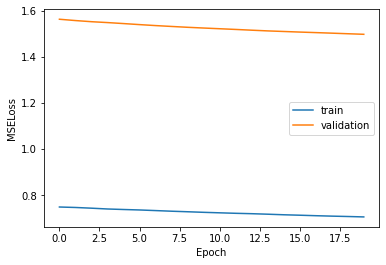

In [40]:
NUM_EPOCHS = 20
train_its = int(np.ceil(training_kp.size(0)/batch_size))
timer_beg = timer()
tr_losses = []

val_losses = []

model.train()
for i in range(NUM_EPOCHS):
    # Init the hidden state (ht, ct)
    h = model.init_hidden(batch_size)
    batch_losses = []
    train_MPJPE = []
    for inputs, labels in train_loader:
        h = tuple([e.data for e in h])
        inputs, labels = inputs.to(device), labels.to(device)
        # Clear the gradients
        optimizer.zero_grad()
        # Forward step
        output, h = model(inputs, h)
        # Loss calculation and backward step
        loss = loss_function(output, labels.float())
        loss.backward()
        # Weight update
        optimizer.step()
        
        # Output data collection for showing
        batch_losses.append(loss.item())   
        rooted_o, rooted_l = substract_root_PJPE(output), substract_root_PJPE(labels)
        train_MPJPE.append(rooted_o.sub(rooted_l).abs().mean().item())
    timer_end = timer()
    tr_losses.append(np.mean(batch_losses))
    writer.add_scalar('Loss/train', tr_losses[-1], i)
    train_MPJPE_total = np.mean(train_MPJPE)
    
    # Validation at the end of an epoch
    val_h = model.init_hidden(batch_size)
    model.eval()
    val_loss = []
    val_MPJPE = []
    for inp, lab in val_loader:
        val_h = tuple([each.data for each in val_h])
        inp, lab = inp.to(device), lab.to(device)
        out, val_h = model(inp, val_h)
        val_loss.append(loss_function(out, lab.float()).item())
        rooted_o, rooted_l = substract_root_PJPE(out), substract_root_PJPE(lab)
        val_MPJPE.append(rooted_o.sub(rooted_l).abs().mean().item())
    val_losses.append(np.mean(val_loss))
    writer.add_scalar('Loss/validation', val_losses[-1], i)  
    val_MPJPE_total = np.mean(val_MPJPE)
    model.train()
    
    # Output loss and training time.
    print(f"Finished epoch {i+1}/{NUM_EPOCHS} in {(timer_end-timer_beg):.2f}s.\n",
             f"Loss: {np.mean(tr_losses[-1]):.4f}",
             f" Val Loss: {val_losses[-1]:.4f}\n"
             f"Train MPJPE: {train_MPJPE_total*stdz:.4f}", f" Val MPJPE: {val_MPJPE_total*stdz:.4f}")
    timer_beg = timer()

plt.plot(tr_losses, label='train')
plt.plot(val_losses, label='validation')
plt.xlabel('Epoch')
plt.ylabel('MSELoss')
plt.legend()

In [43]:
zeros = torch.zeros(138, device='cuda:0')
count=0
for frame in output[0]:
    if torch.all(frame.eq(zeros)):
        count +=1
print(count)
count = 0
for frame in labels[0]:
    if torch.all(frame.eq(zeros)):
        count +=1
print(count)

0
1798


In [44]:
torch.save(model.state_dict(), f'./{name}.pt')

In [45]:
model.load_state_dict(torch.load(f'./{name}.pt'))

<All keys matched successfully>

## Testing
After the training, we shall proceed with the performance test. This will go through the test batches and perform the inference, then it will show the test loss, as well as the performance metric. In this case, as we are working with human body keypoints, we will use the Mean Per Joint Position Error (MPJPE) metric, which outputs the mean euclidean distance between the joints (keypoints) positions estimated and the ones in the groundtruth.

The formula for MPJPE is the following:

$\text{MPJPE} = \frac1T\frac1N\displaystyle\sum_{t=1}^{T}\displaystyle\sum_{i=1}^{N}\|(J_{i}^{(t)}-J_{root}^{(t)})-(Ĵ_{i}^{(t)}-Ĵ_{root}^{(t)})\|$

Where N is the number of joints, and T the number of samples.

As we have seen in the formula above, we need to align the root joints of the labels and the network output. In order to do that, I have defined a function (`substract_root_PJPE`) that substracts the root joint of each keypoint set (face, hands, body) in the corresponding keypoint set.

In [46]:
test_losses = []
MPJPE = []
h = model.init_hidden(batch_size)

model.eval()
for inputs, labels in test_loader:
    h = tuple([each.data for each in h])
    inputs, labels = inputs.to(device), labels.to(device)
    output, h = model(inputs, h)
    test_loss = loss_function(output, labels.float())
    test_losses.append(test_loss.item())
    rooted_o, rooted_l = substract_root_PJPE(output), substract_root_PJPE(labels)
    MPJPE.append(rooted_o.sub(rooted_l).abs().mean().item())
MPJPE_total = np.mean(MPJPE)

In [47]:
print(f"MPJPE: {MPJPE_total*stdz:.4f}", f"\nTest loss: {np.mean(test_losses):.4f}")

MPJPE: 6.8005 
Test loss: 0.7630
